## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
# ML imports
import torch
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torchvision import transforms

from avalanche.training import Naive, Replay

# from avalanche.models import SimpleMLP, SimpleCNN
from avalanche.benchmarks.classic import (
    RotatedMNIST,
    PermutedMNIST,
)  # ,PermutedOmniglot, RotatedOmniglot

import random
import numpy as np
from matplotlib import pyplot as plt

# Local imports
import models
import utils
from nets import SimpleCNN, SimpleMLP


In [14]:
import sklearn

In [33]:
# Config
SEED = 492
device = utils.get_device()

dataset = RotatedMNIST

model = "mlp"
n_classes = 10
n_epochs = 10
n_experiences = 3
input_size = 784
hidden_size = 64

n_hidden_layers = 3
freeze_depth = 1
assert freeze_depth <= n_hidden_layers
latent_layer_number = freeze_depth * 3
freeze_below_layer = "end_features.0"

replay_buffer_size = 10000

train_mb_size = 128
eval_mb_size = 1024

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

sanity_check_ablation_naive = {
    "latent_layer_number": 0,
    "replay_buffer_size": 0,
}
sanity_check_ablation_replay = {
    "latent_layer_number": 0,
    "replay_buffer_size": 1500,
}
sanity_check_ablation_latent_replay = {
    "latent_layer_number": 1,
    "replay_buffer_size": 1500,
}



In [34]:
# Prepare for training & testing
l2 = 0.0005
momentum = 0.9
lr = 0.001

# Model
model_2 = SimpleMLP(
    hidden_layers=n_hidden_layers,
    num_classes=n_classes,
    hidden_size=hidden_size,
)


# CL strategy
naive_strategy = Naive(
    model=model_2,
    criterion=CrossEntropyLoss(),
    optimizer=SGD(model_2.parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    device=device,
)

replay_strategy = Replay(
    model=model_2,
    criterion=CrossEntropyLoss(),
    optimizer=SGD(model_2.parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    device=device,
)



In [35]:
# Model
if model == "mlp":
    model = SimpleMLP(
        hidden_layers=n_hidden_layers,
        num_classes=n_classes,
        hidden_size=hidden_size,
    )
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))]
    )

elif model == "cnn":
    model = SimpleCNN(num_classes=n_classes)
    transform = transforms.Compose([transforms.ToTensor()])

else:
    # CL Benchmark Creation
    # Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
    transform = transforms.Compose(
        [
            # transforms.Lambda(lambda x: x.convert('RGB')),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        ]
    )


# Prepare for training & testing

# Continual learning strategy
# cl_strategy = models.LatentReplay(criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, device=device)

cl_strategy = models.LatentReplay(
    model=model,
    criterion=CrossEntropyLoss(),
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=latent_layer_number,
    freeze_below_layer=freeze_below_layer,
    device=device,
)



FrozenNet(
  (lat_features): Sequential(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (end_features): Sequential(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): LazyLinear(in_features=0, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)


In [36]:
for model, results in [
    (cl_strategy, (results_ar1 := [])),
    #(naive_strategy, (results_naive := [])),
    #(replay_strategy, (results_naive := [])),
]:
    experiences = dataset(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
        rotations_list=[0,300,60]
    )
    train_stream = experiences.train_stream
    test_stream = experiences.test_stream

    for train_exp in train_stream:
        model.train(train_exp)
        results.append(model.eval(train_stream))


-- >> Start of training phase << --
100%|██████████| 469/469 [00:18<00:00, 25.25it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2957
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1365
100%|██████████| 469/469 [00:17<00:00, 27.37it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2461
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2515
100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.0151
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3275
100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5395
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4709
100%|██████████| 469/469 [00:16<00:00, 28.99it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1884
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5881
100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
Epoch 5 ended.
	Loss_Epoch/tr

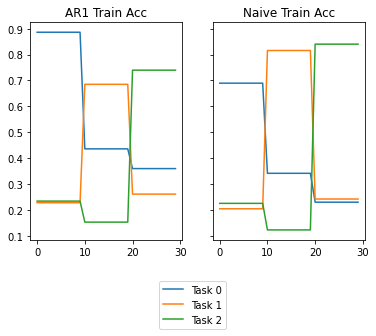

In [37]:
# JA: Next step - replace internal model.
# - model def              ✅
# - frozen layer name      ✅
# - batch renorm stuff...? ✅

# JA: 2nd step
# - check replays work                      ✅
# - check replays work for subsequent exp's ✅
# - check latent replays work               ✅

# JA: 3rd step
# - make GMM
# - add GMM to model sampler

fig, axes = plt.subplots(1, 2, sharey=True)
repeat_vals = 10

try:
    results_ar1_clean = utils.plot_results(
        results_ar1, "AR1", axes[0], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass
try:
    results_naive_clean = utils.plot_results(
        results_naive, "Naive", axes[1], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass

utils.plot_single_legend(fig)


c:\Users\jacob\anaconda3\envs\env-glr\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jacob\anaconda3\envs\env-glr\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jacob\anaconda3\envs\env-glr\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jacob\anaconda3\envs\env-glr\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarn

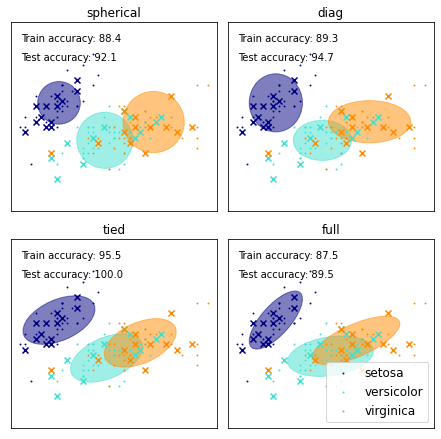

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["navy", "turquoise", "darkorange"]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()